In [3]:
library(tidyverse)
library(tidymodels)
library(repr)
library(dplyr)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [4]:
heart_data <- read_csv("heart_data.csv") |>
select(chol, trestbps, fbs, age, sex, num) |>
mutate(sex = as_factor(sex))|>
mutate(sex = fct_recode(sex, "male" = "1", "female" = "0")) |>
mutate(fbs = as_factor(fbs)) |>
mutate(fbs = fct_recode(fbs, "true" = "1", "false" = "0")) |>
rename("fbs_gt_120" = "fbs") |>
mutate(num = as_factor(num)) 
heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


chol,trestbps,fbs_gt_120,age,sex,num
<dbl>,<dbl>,<fct>,<dbl>,<fct>,<fct>
233,145,true,63,male,0
286,160,false,67,male,2
229,120,false,67,male,1
⋮,⋮,⋮,⋮,⋮,⋮
131,130,false,57,male,3
236,130,false,57,female,1
175,138,false,38,male,0


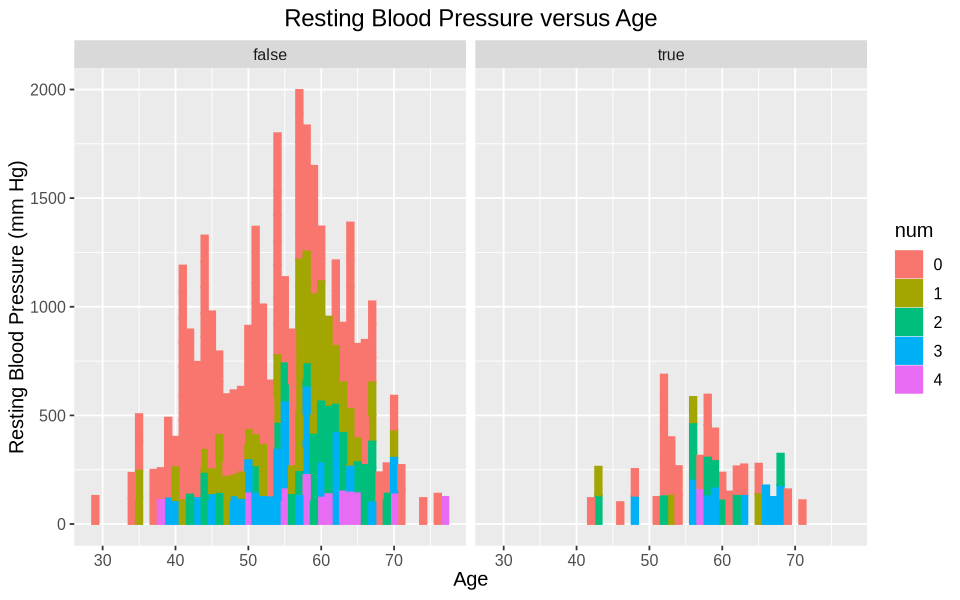

In [14]:
options(repr.plot.width = 8, repr.plot.height = 5)

heart_data_plot_2 <- heart_data |> 
            # should be changing true and false to human readable labels 
            ggplot(aes(x= age, y= trestbps, color = num, fill = num)) +
            geom_bar(stat = "identity")+ 
            labs(x= "Age", y = "Resting Blood Pressure (mm Hg)", title = "Resting Blood Pressure versus Age", num = "Diagnosis of Heart Disease")+ # rename false and true 
            facet_grid(col = vars(fbs_gt_120)) + # add a legend for integers 1 to 4 
            theme(text = element_text(size = 12)) +
theme(plot.title = element_text(hjust = 0.5))
heart_data_plot_2 